In [ ]:
pip install dowhy

In [ ]:
import dowhy
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [ ]:
house_df = pd.read_csv('./kc_house_data.csv')

In [ ]:
display(house_df['lat'].describe())
display(house_df['long'].describe())

count    21613.000000
mean        47.560053
std          0.138564
min         47.155900
25%         47.471000
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64

count    21613.000000
mean      -122.213896
std          0.140828
min       -122.519000
25%       -122.328000
50%       -122.230000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

In [ ]:
house_df['location'] = house_df['long'].apply(lambda x : 'sub' if x>= -122.008921 else 'urban')

In [ ]:
house_df['location'].value_counts()

urban    19917
sub       1696
Name: location, dtype: int64

In [ ]:
df = house_df.set_index('yr_built')

In [ ]:
final_data = df.loc[[2000,2001,2002,2003,2004,2005,2006,2007]]

In [ ]:
final_data['location'].value_counts()

urban    2388
sub       533
Name: location, dtype: int64

In [ ]:
grouped = final_data.groupby(['yr_built','location']).mean()

In [ ]:
grouped

id          price  ...  sqft_living15    sqft_lot15
yr_built location                               ...                             
2000     sub       4.953383e+09  651377.076923  ...    2575.128205  44393.410256
         urban     5.053772e+09  688415.268156  ...    2301.703911  16120.916201
2001     sub       5.404295e+09  663069.083333  ...    2801.666667  33203.266667
         urban     4.808596e+09  760123.461224  ...    2414.236735  10770.963265
2002     sub       5.703792e+09  620728.205128  ...    2702.820513  37229.435897
         urban     4.631391e+09  569668.868852  ...    2307.147541  10141.387978
2003     sub       4.981731e+09  589266.406780  ...    2556.271186  28358.847458
         urban     4.712107e+09  553725.231405  ...    2277.763085   8759.586777
2004     sub       5.479380e+09  633620.050000  ...    2806.510000  22355.880000
         urban     5.253256e+09  584701.057057  ...    2252.228228   8729.825826
2005     sub       4.231573e+09  606428.105263  ...    2567.821053  20117.389474
         urban     4.423745e+09  573956.087324  ...    2179.577465   7029.571831
2006     sub       5.331940e+09  682172.229885  ...    2977.321839  21009.356322
         urban     5.212244e+09  618720.896458  ...    2135.239782   6840.787466
2007     sub       4.915579e+09  692330.555556  ...    2801.277778  37074.814815
         urban     4.600379e+09  603501.523416  ...    1934.217631   6549.573003

[16 rows x 19 columns]

# XGBRegressor

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


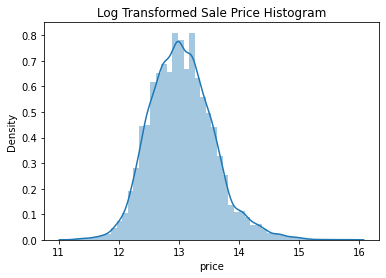

In [ ]:
plt.title('Log Transformed Sale Price Histogram')
log_scale = np.log1p(house_df['price'])
sns.distplot(log_scale)

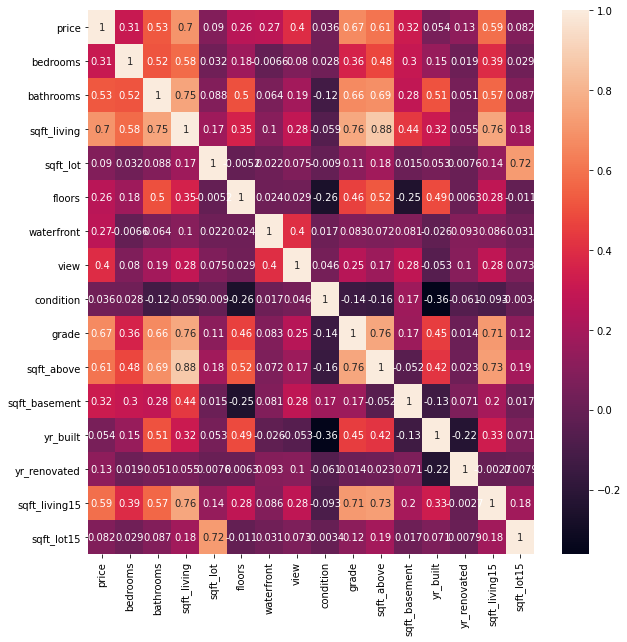

In [ ]:
plt.figure(figsize = (10,10))

sns.heatmap(house_df.corr(),annot=True)
plt.show()

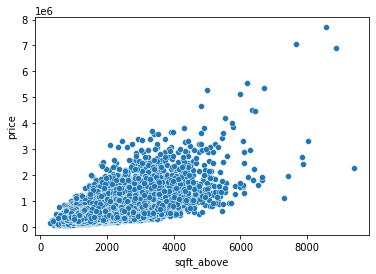

In [ ]:
sns.scatterplot(x='sqft_above', y='price',data=house_df)

In [ ]:
y = house_df['price']
X = house_df.drop('price',axis=1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge = Ridge()
ridge.fit(X_train,y_train)

lasso = Lasso()
lasso.fit(X_train,y_train)

models = [lr_reg,ridge,lasso]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314509192140477.06, tolerance: 202200761153.97137
  positive)


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse,3)}')
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X, y)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 234751.228 
[14:52:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 180277.789 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 186955.435 


In [ ]:
xbg_reg = XGBRegressor(n_estimators = 1000, random_state=156, learning_rate = 0.02, max_depth = 7,
                       min_child_weight = 3, colsample_bytree = 0.5, reg_alpha = 0.03)

xgb_reg.fit(X_train,y_train,early_stopping_rounds = 200, verbose=False,
           eval_metric = "rmse", eval_set = [(X_train,y_train),(X_test,y_test)])

[14:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

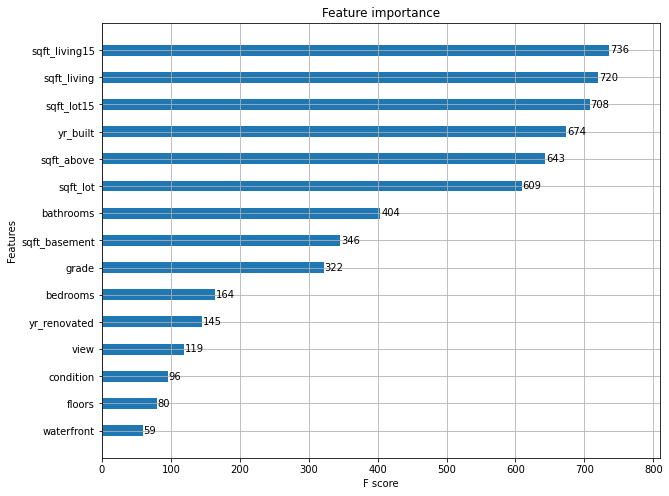

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_reg, ax=ax, max_num_features=20, height=0.4)

# Dowhy

In [ ]:
house_df['sqft_above'] = house_df['sqft_above'].apply(lambda x: True if x>=1560 else False)

In [ ]:
causal_graph = """
digraph {
sqft_above;
price;
floor;
U[label="Unobserved Confounders"];
floor -> sqft_above; floor -> bathrooms;
floor -> sqft_living; sqft_living->price;
U->bathrooms;U->bedrooms;U->floor;
bathrooms -> price; bedrooms -> price;
floor -> price;sqft_above -> price
}
"""

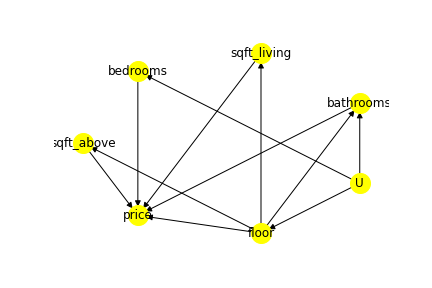

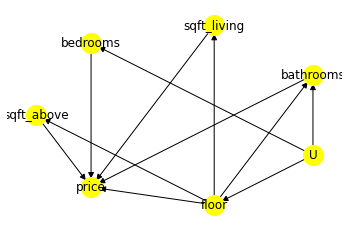

In [ ]:
from dowhy import CausalModel
from IPython.display import Image, display
model= CausalModel(
        data = house_df,
        graph=causal_graph.replace("\n", " "),
        treatment='sqft_above',
        outcome='price')
model.view_model()
display(Image(filename="causal_model.png"))

In [ ]:
identified = model.identify_effect()

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


In [ ]:
method_matching = model.estimate_effect(identified,method_name = "backdoor.propensity_score_matching")
method_stratify = model.estimate_effect(identified,method_name = "backdoor.propensity_score_stratification")

print("Causal Estimate of Matching: {}".format(method_matching.value))
print("Causal Estimate of Stratification: {}".format(method_stratify.value))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Causal Estimate of Matching: 35711.471429232406
Causal Estimate of Stratification: 16722.307811138675


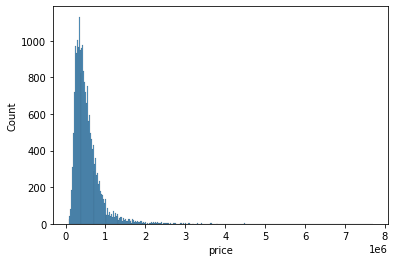

In [ ]:
sns.histplot(data = house_df, x= 'price')

In [ ]:
random_matching = model.refute_estimate(identified, method_matching,method_name="random_common_cause")
random_str = model.refute_estimate(identified, method_stratify,method_name="random_common_cause")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

In [ ]:
print(random_matching)
print(random_str)

Refute: Add a Random Common Cause
Estimated effect:35711.471429232406
New effect:42234.011011890994

Refute: Add a Random Common Cause
Estimated effect:16722.307811138675
New effect:15939.815130237164

